In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
import cartopy.crs as ccrs
import colormaps as clm
import matplotlib as mpl

/usr/local/lib/python3.8/dist-packages/tslearn/clustering/kmeans.py:20: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


# データの準備

In [2]:
path = "/docker/mnt/d/research/D2/cnn3/predictant/continuous/pr_1x1_std_MJJASO_thailand.npy"

In [3]:
x = np.load(path)
print(x.shape)

(42, 165, 20, 20)


In [4]:
AWI = x[0, :, :, :].reshape(165, 400)
AWI = AWI.T
print(AWI.shape)

(400, 165)


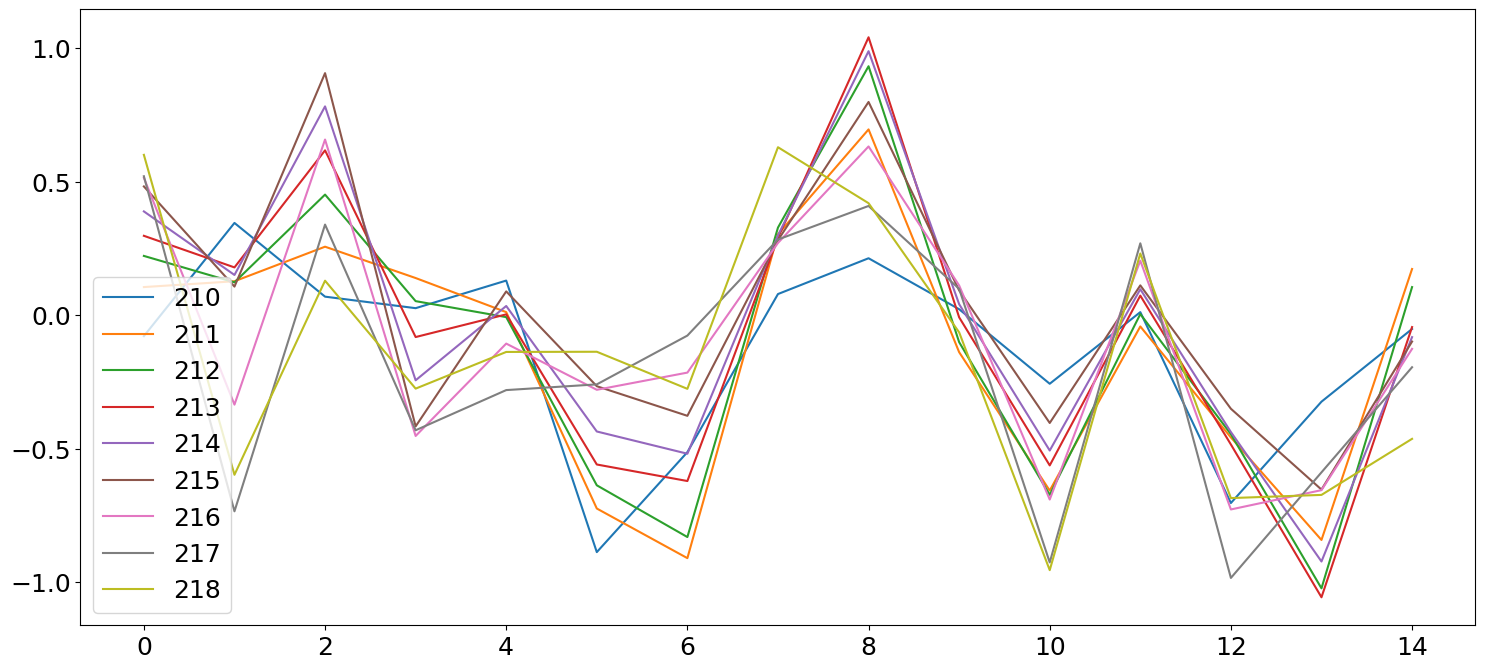

In [49]:
# 代替横方向で同じような波形なのは４くらい？
# 縦にも4くらいと考えると
# 16で1クラスターなので，
# 25クラスターが妥当なのでは？
grid_list = [#100,
             #101,
             #102,
             210,
             211,
             212,
             213,
             214,
             215,
             216,
             217,
             218,
            ]
fig, axes = plt.subplots(figsize=(18, 8))
for i in grid_list:
    plt.plot(AWI[i, :15] ,label=f"{i}")
plt.legend()
plt.show()

# クラスタリング実行

In [7]:
n = 10 # クラスタ数

km_dtw = TimeSeriesKMeans(n_clusters=n,
                          random_state=42,
                          metric="dtw")

In [9]:
# タプルだからarrayに直さないといけない
# fit_predictは0次元目を観測点，1次元目を時系列データとして認識する

awi_labels = km_dtw.fit_predict(AWI)
awi_flat = awi_labels[:]
awi_map = np.reshape(awi_flat, (20, 20))
print(awi_flat.shape, awi_flat)

(400,) [0 0 9 1 9 3 3 3 3 3 6 6 6 6 6 6 6 6 6 6 0 0 0 7 3 3 3 3 3 3 3 6 6 6 6 6 6
 6 6 6 0 0 0 0 3 3 3 3 3 3 3 3 6 6 6 6 6 6 6 6 0 0 0 0 0 3 3 3 3 3 3 3 3 3
 6 6 6 6 8 8 0 0 0 0 0 0 3 3 3 3 3 3 3 3 6 6 8 8 8 8 0 0 0 0 0 0 0 0 3 3 3
 3 3 3 3 8 8 8 8 8 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 8 8 8 8 8 1 1 1 1 5 0 0 0
 2 2 2 2 2 2 2 2 8 8 8 8 7 1 1 1 1 1 5 5 5 5 5 2 2 2 2 2 2 8 8 8 7 1 1 1 1
 1 1 5 5 5 5 5 2 2 2 2 2 2 8 8 7 1 1 1 1 1 1 1 5 5 5 5 2 2 2 2 4 4 2 8 7 7
 7 1 1 1 1 1 1 5 5 5 5 2 4 4 4 4 4 4 7 7 7 7 1 1 1 1 1 5 5 1 5 4 4 4 4 4 4
 4 7 7 7 7 7 1 1 1 1 5 1 1 1 5 4 4 4 4 4 4 7 7 7 7 7 1 1 1 1 1 1 1 1 1 4 4
 4 4 2 7 7 7 7 7 7 7 1 1 1 1 1 1 1 1 1 4 4 4 7 1 7 7 7 7 7 7 7 1 9 9 9 7 1
 1 1 1 9 9 1 1 9 9 9 9 9 7 7 9 9 9 9 9 1 1 1 1 1 1 1 1 9 9 9 9 9 9 9 9 9 9
 9 4 9 1 1 1 1 1 1 1 9 9 9 9 9 9 9 9 9 9 9 4 9 9 1 1 1 1 1 1]


# Elbow method

In [10]:
def elbow(data):
    distortions = []
    for i in range(1, 11):
        km_elb = TimeSeriesKMeans(n_clusters=i,
                                  random_state=42,
                                  metric="dtw")
        km_elb.fit(data)
        distortions.append(km_elb.inertia_)
        print(f"cluster {i} done")
    
    plt.plot(range(1, 11), distortions, marker='o')
    plt.show()

cluster 1 done
cluster 2 done
cluster 3 done
cluster 4 done
cluster 5 done
cluster 6 done
cluster 7 done
cluster 8 done
cluster 9 done
cluster 10 done


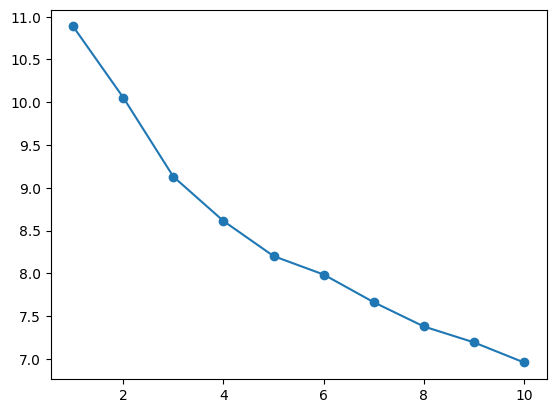

In [11]:
elbow(AWI)

# 可視化

In [50]:
def draw_map(label, cluster_num=5):
    plt.rcParams["font.size"] = 18
    projection = ccrs.PlateCarree(central_longitude=180)
    img_extent = (-90, -70, 5, 25)
    
    cm = plt.cm.get_cmap('tab20', cluster_num)

    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(label,
                     origin='upper',
                     extent=img_extent,
                     transform=projection,
                     cmap=cm,
                    )
    cbar = fig.colorbar(mat, ax=ax)
    plt.show()

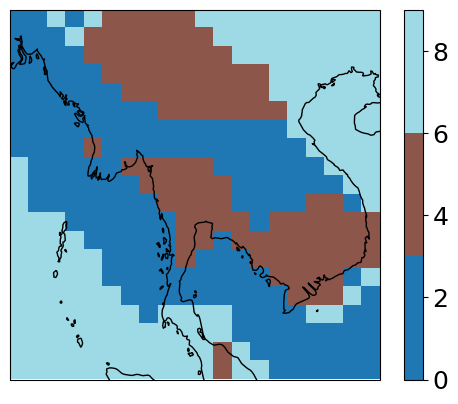

In [51]:
draw_map(awi_map, cluster_num=n)

In [52]:
def plot_km(data, labels, km, cluster_num=3):
    fig, axes = plt.subplots(n, figsize=(8, 18))
    plt.subplots_adjust(hspace=0.5)
    for i in range(cluster_num):
        ax = axes[i]
        for xx in data[labels == i]:
            ax.plot(xx.ravel()[:10], "k-", alpha=.01)
        ax.plot(km.cluster_centers_[i].ravel()[:10], "r-")
    plt.show()

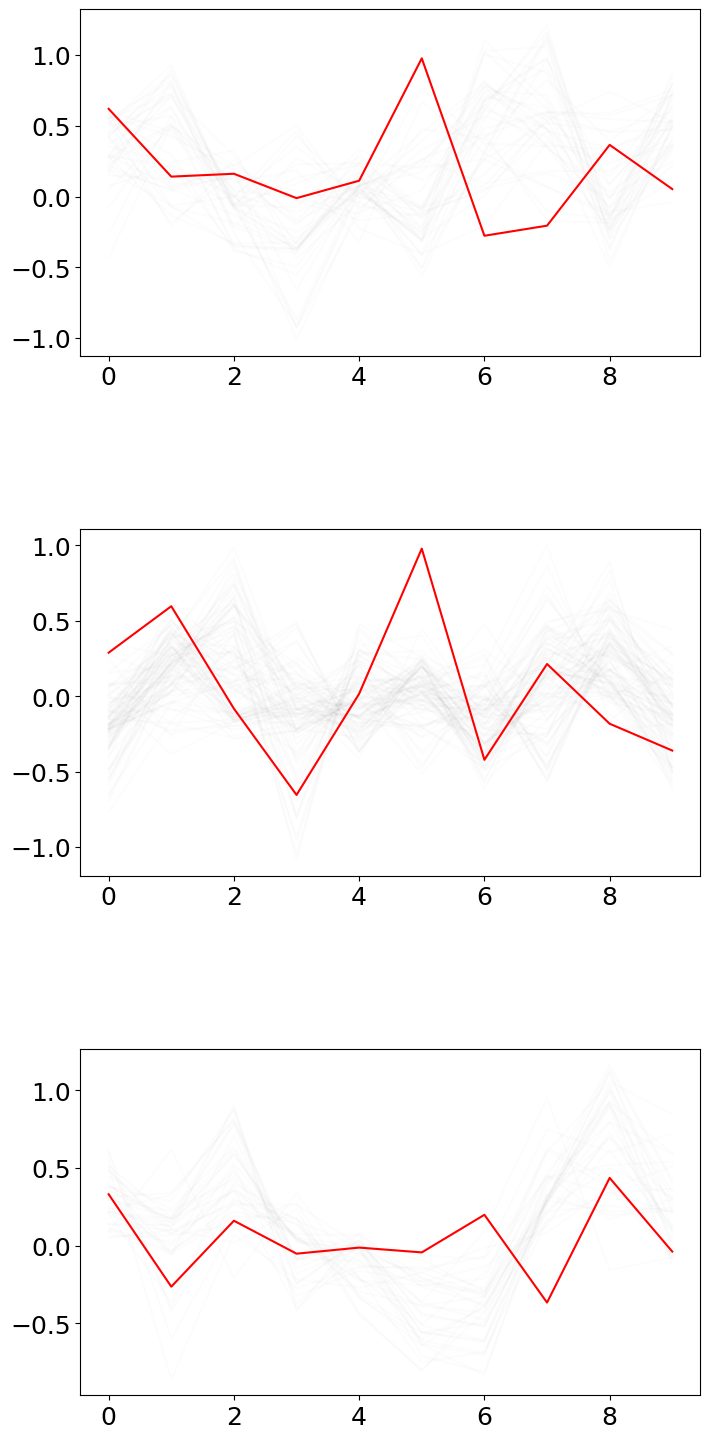

In [53]:
plot_km(AWI, awi_labels, km_dtw, cluster_num=n)

# 比較実験

In [22]:
n = 3 # クラスタ数

km_dtw = TimeSeriesKMeans(n_clusters=n,
                          random_state=42,
                          metric="dtw")

(400,) [0 1 1 1 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2
 2 2 2 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 0 0 0 0 0 0 0 1 1 1 1 1 2 2
 2 2 2 2 2 2 0 0 0 0 1 1 1 1 2 1 1 1 2 2 2 2 2 2 2 2 0 0 0 0 0 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 1 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 1 1 0 0 0 0 1 1 1 1
 2 1 2 2 2 2 2 2 2 2 1 1 1 0 1 1 1 0 1 0 1 2 2 2 2 2 2 1 0 0 1 2 0 0 0 1 1
 1 0 1 1 1 2 2 2 2 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 2 2 2 1 1 1 1 1 1 1 0 0
 1 0 0 1 2 1 1 1 2 2 2 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 2 1 2 1 1 1 1 2 1 1
 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


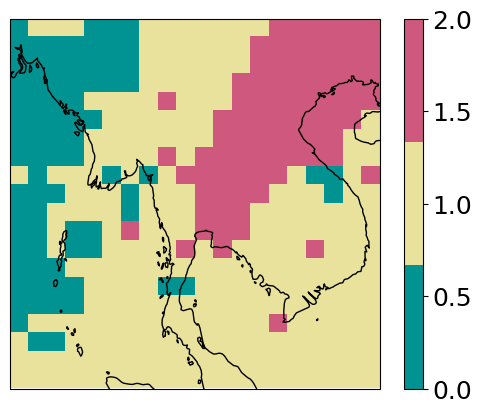

In [23]:
BCC = x[1, :, :, :].reshape(165, 400)
BCC = BCC.T
bcc_labels = km_dtw.fit_predict(BCC)
bcc_flat = bcc_labels[:]
bcc_map = np.reshape(bcc_flat, (20, 20))
print(bcc_flat.shape, bcc_flat)
draw_map(bcc_map, cluster_num=n)

(400,) [1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 1 1 2
 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 1
 1 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0
 0 0 1 1 1 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


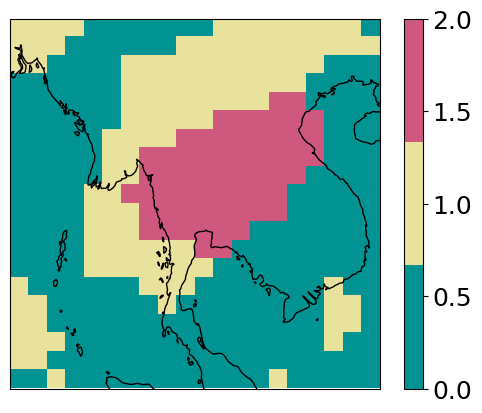

In [24]:
BCC2 = x[2, :, :, :].reshape(165, 400)
BCC2 = BCC2.T
bcc2_labels = km_dtw.fit_predict(BCC2)
bcc2_flat = bcc2_labels[:]
bcc2_map = np.reshape(bcc2_flat, (20, 20))
print(bcc2_flat.shape, bcc2_flat)
draw_map(bcc2_map, cluster_num=n)

(400,) [0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2
 2 2 2 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 2 2 2 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0
 2 2 2 2 2 2 2 2 1 0 0 0 0 0 0 0 0 1 1 0 0 2 2 2 2 2 2 2 1 0 0 0 0 0 0 0 1
 1 1 1 1 1 2 2 2 2 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1]


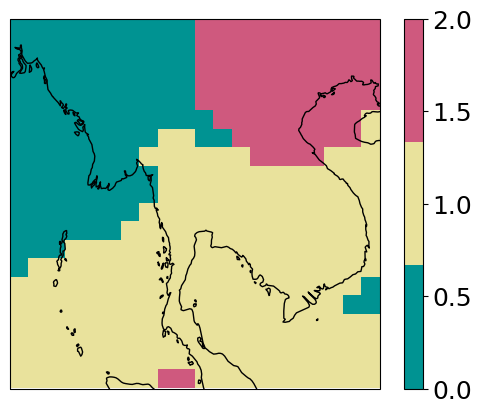

In [25]:
CAS = x[3, :, :, :].reshape(165, 400)
CAS = CAS.T
cas_labels = km_dtw.fit_predict(CAS)
cas_flat = cas_labels[:]
cas_map = np.reshape(cas_flat, (20, 20))
print(cas_flat.shape, cas_flat)
draw_map(cas_map, cluster_num=n)

(400,) [0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 1 1 1 1 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 2 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 1 1 1 1 1 1 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1]


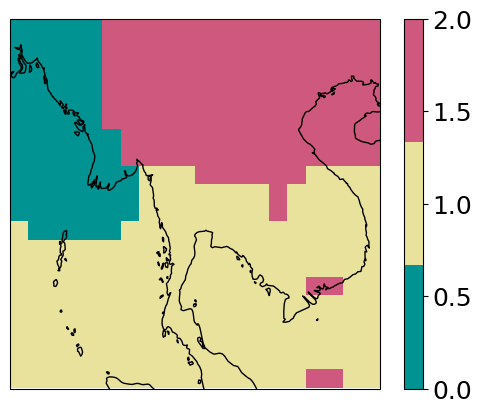

In [26]:
CESM = x[4, :, :, :].reshape(165, 400)
CESM = CESM.T
cesm_labels = km_dtw.fit_predict(CESM)
cesm_flat = cesm_labels[:]
cesm_map = np.reshape(cesm_flat, (20, 20))
print(cesm_flat.shape, cesm_flat)
draw_map(cesm_map, cluster_num=n)

(400,) [2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 2 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 2 2 2 0 0 0 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 2 2 2 2 2 2 0
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 2
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 2 2 2 2 2 0 2 2 2 0 0 2 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 2
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0
 0 0 0 0 1 1 1 1 2 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 1 1 1 0 0 0]


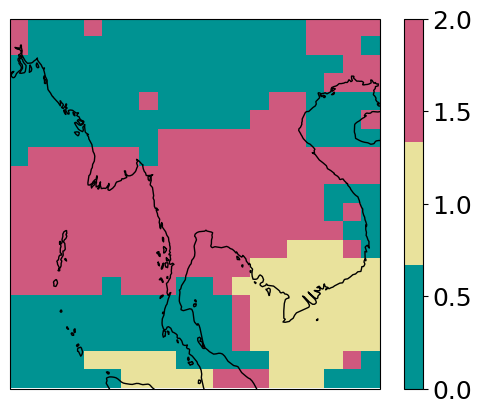

In [29]:
CESM2 = x[5, :, :, :].reshape(165, 400)
CESM2 = CESM2.T
cesm2_labels = km_dtw.fit_predict(CESM2)
cesm2_flat = cesm2_labels[:]
cesm2_map = np.reshape(cesm2_flat, (20, 20))
print(cesm2_flat.shape, cesm2_flat)
draw_map(cesm2_map, cluster_num=n)

(400,) [1 1 1 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 1 1 0 0 0 0 2 2 0 2 2 2 2 2 2 2 2
 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 2 0 0 0 2 2 2 2 2 1 2 2 2 2 2
 2 2 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2
 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1]


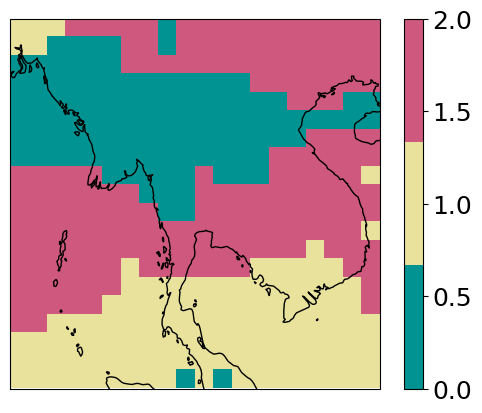

In [28]:
CESM3 = x[6, :, :, :].reshape(165, 400)
CESM3 = CESM3.T
cesm3_labels = km_dtw.fit_predict(CESM3)
cesm3_flat = cesm3_labels[:]
cesm3_map = np.reshape(cesm3_flat, (20, 20))
print(cesm3_flat.shape, cesm3_flat)
draw_map(cesm3_map, cluster_num=n)

(400,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 2 2 2 2
 2 2 2 2 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2]


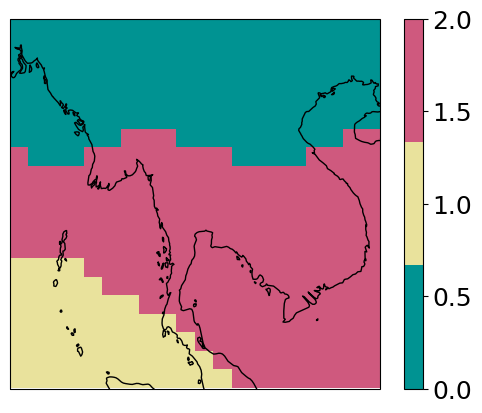

In [30]:
CMCC = x[7, :, :, :].reshape(165, 400)
CMCC = CMCC.T
cmcc_labels = km_dtw.fit_predict(CMCC)
cmcc_flat = cmcc_labels[:]
cmcc_map = np.reshape(cmcc_flat, (20, 20))
print(cmcc_flat.shape, cmcc_flat)
draw_map(cmcc_map, cluster_num=n)

In [ ]:
CMCC = x[7, :, :, :].reshape(165, 400)
CMCC = CMCC.T
cmcc_labels = km_dtw.fit_predict(CMCC)
cmcc_flat = cmcc_labels[:]
cmcc_map = np.reshape(cmcc_flat, (20, 20))
print(cmcc_flat.shape, cmcc_flat)
draw_map(cmcc_map, cluster_num=n)

# 42モデルのループ試す

In [56]:
def all_models(original):
    number=25
    model = TimeSeriesKMeans(n_clusters=number,
                              random_state=42,
                              metric="dtw",
                            )
    for i in range(42):
        print(f"model index {i}")
        gcm = original[i, :, :, :].reshape(165, 400)
        gcm = gcm.T
        gcm_labels = model.fit_predict(gcm)
        gcm_flat = gcm_labels[:]
        gcm_map = np.reshape(gcm_flat, (20, 20))
        draw_map(gcm_map, cluster_num=number)

model index 0


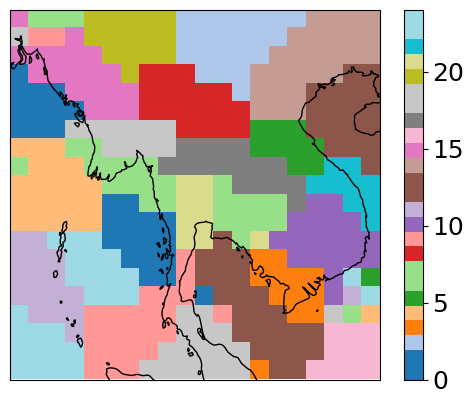

model index 1


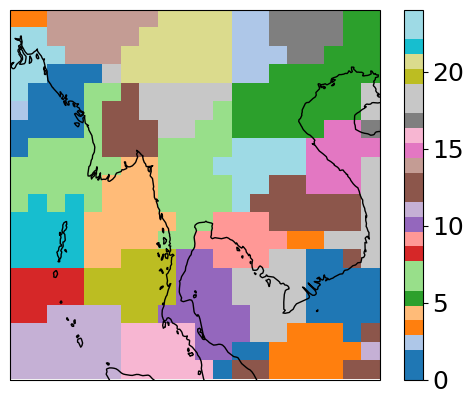

model index 2


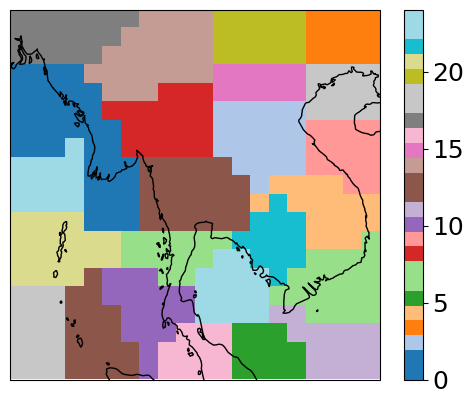

model index 3


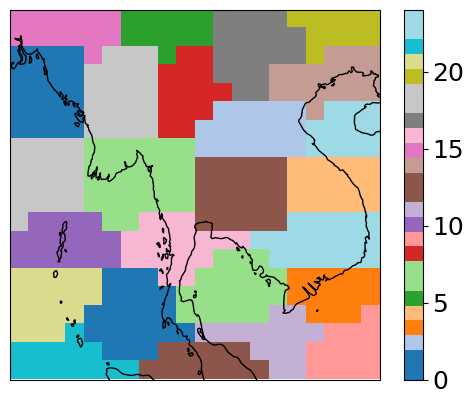

model index 4


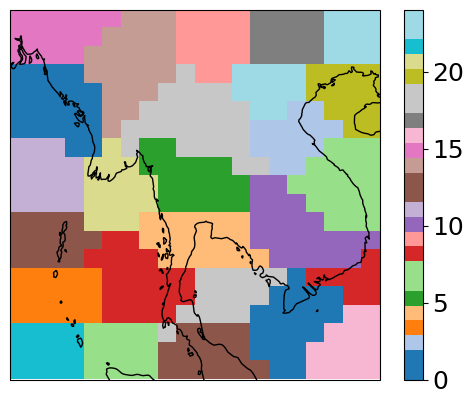

model index 5


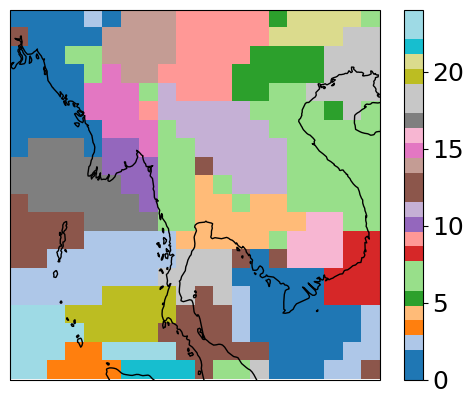

model index 6


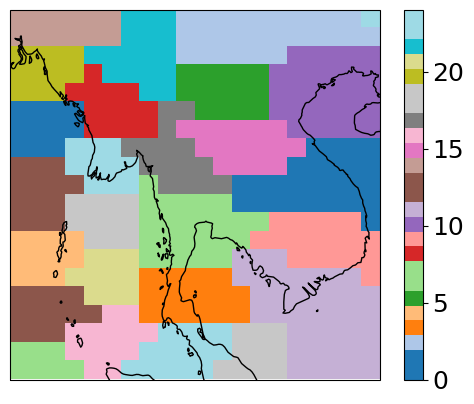

model index 7


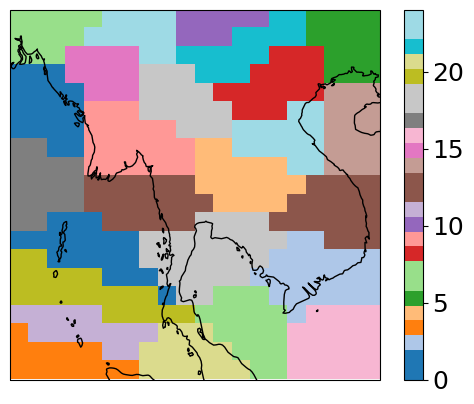

model index 8


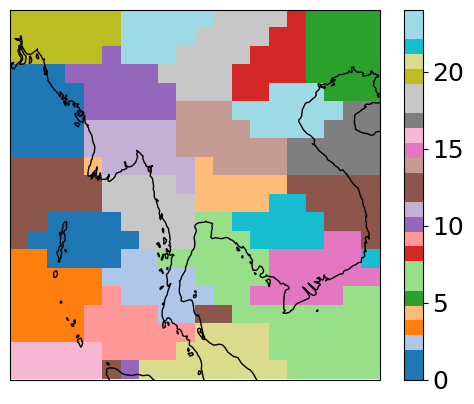

model index 9


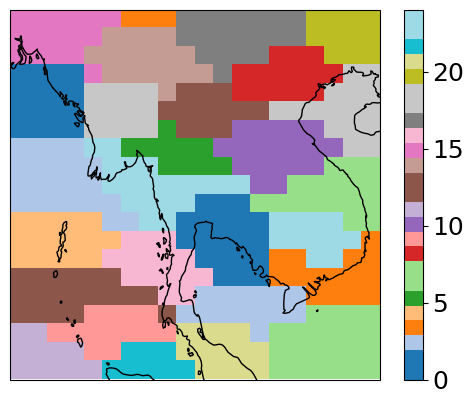

model index 10


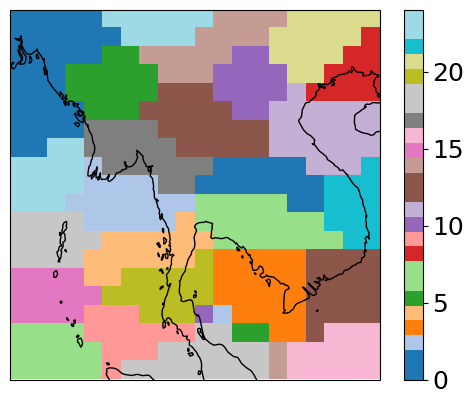

model index 11


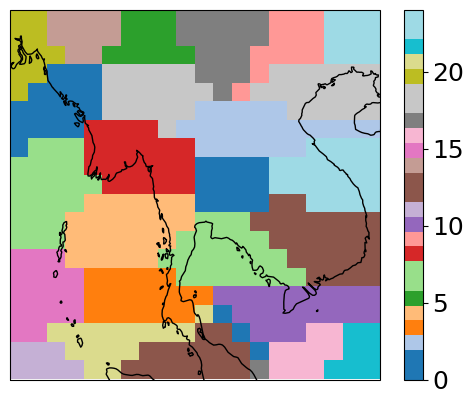

model index 12


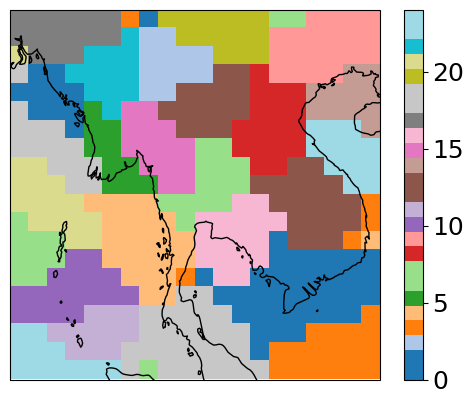

model index 13


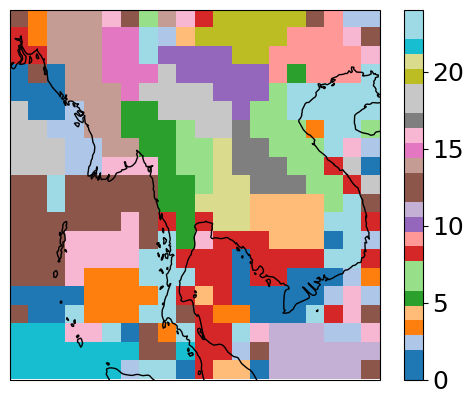

model index 14


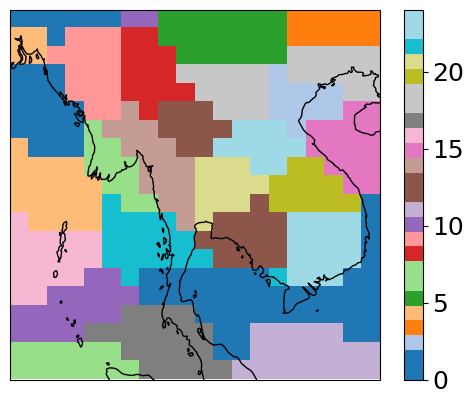

model index 15


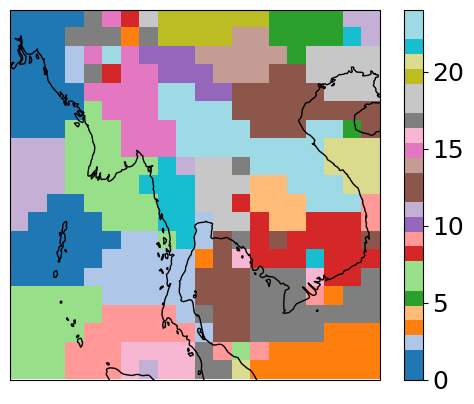

model index 16


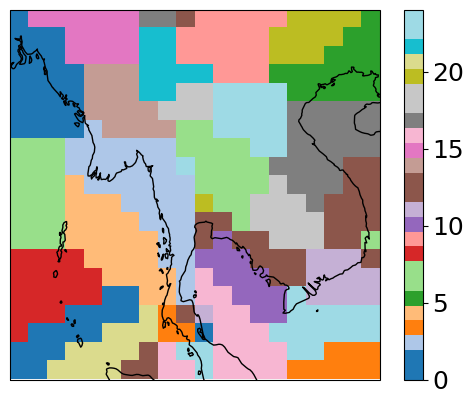

model index 17


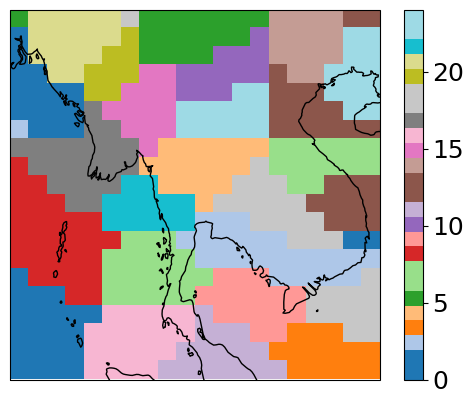

model index 18


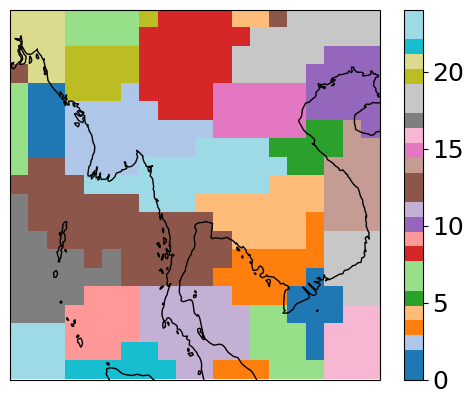

model index 19


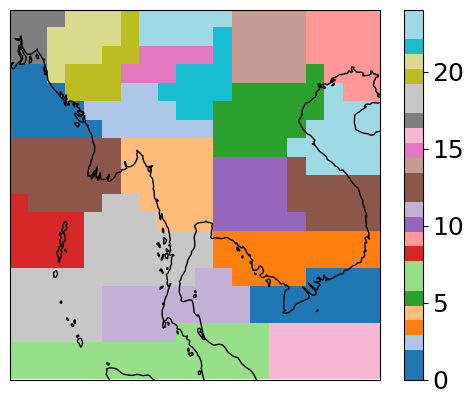

model index 20


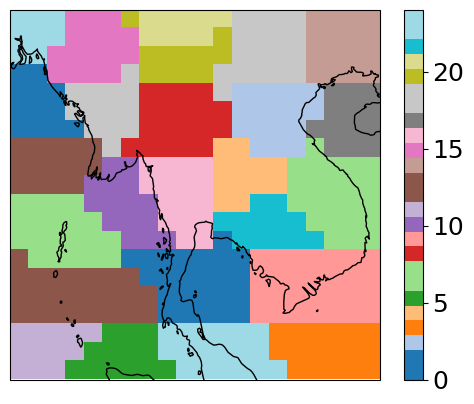

model index 21


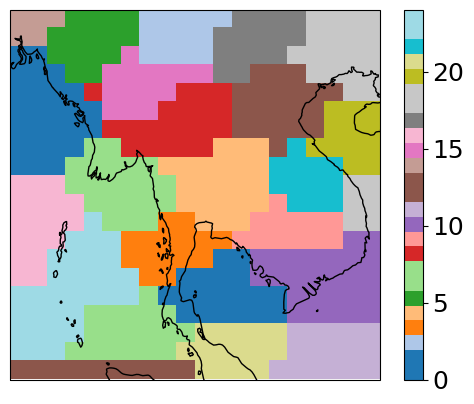

model index 22


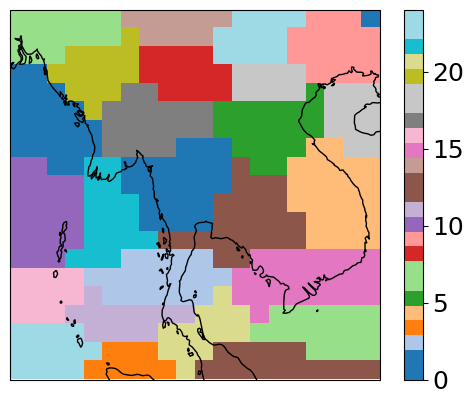

model index 23


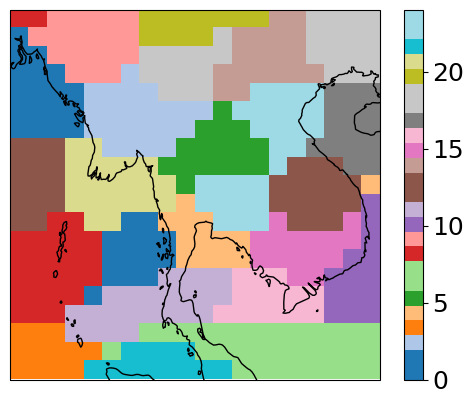

model index 24


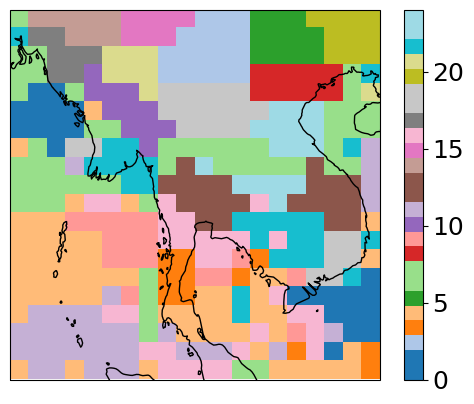

model index 25


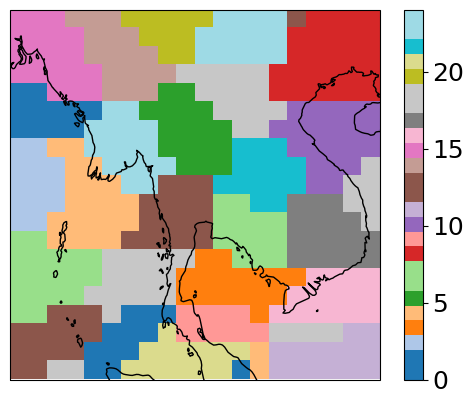

model index 26


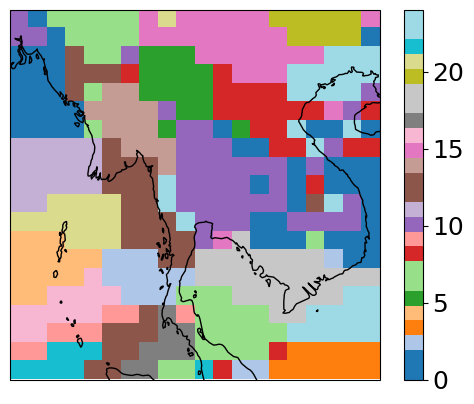

model index 27


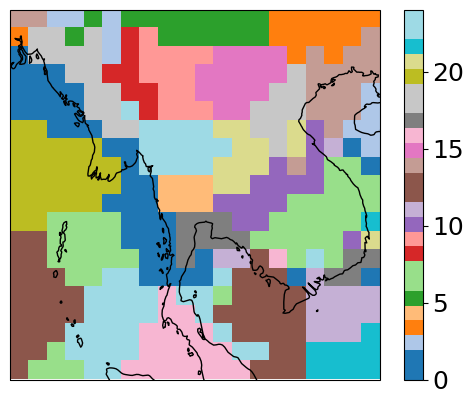

model index 28


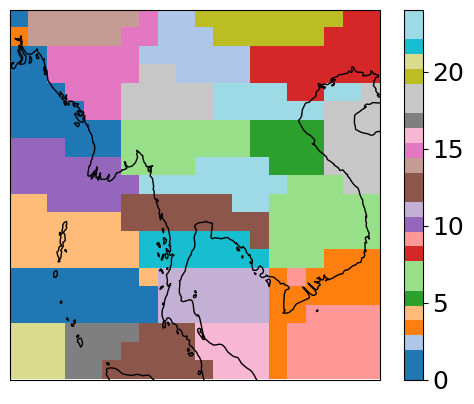

model index 29


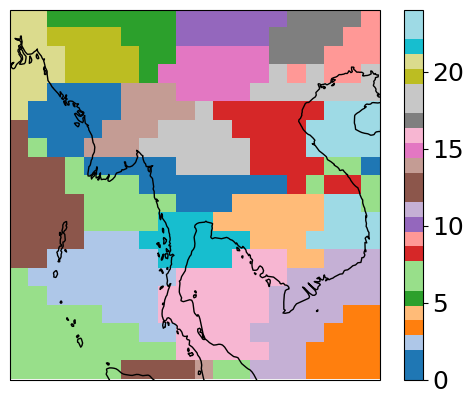

model index 30


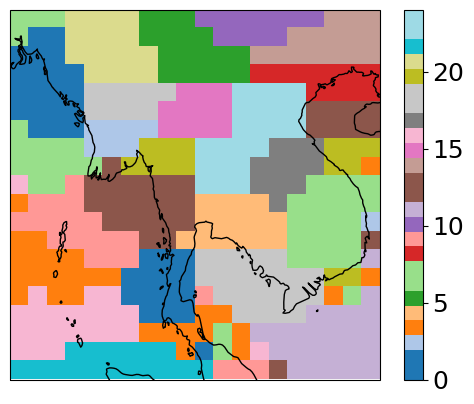

model index 31


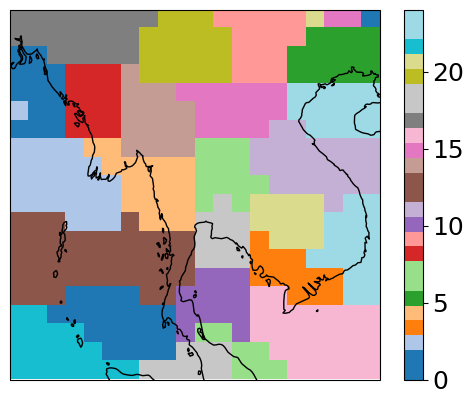

model index 32


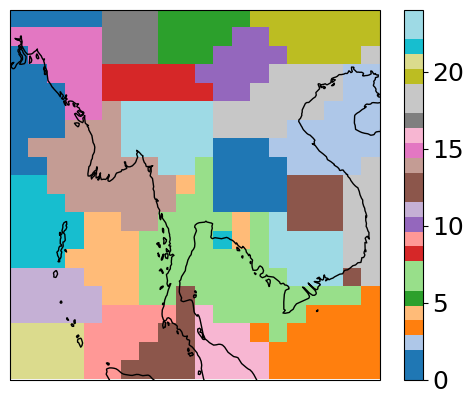

model index 33


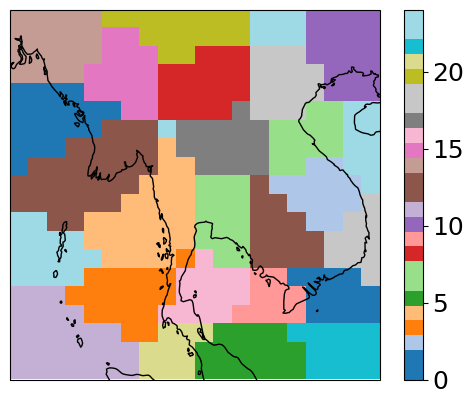

model index 34


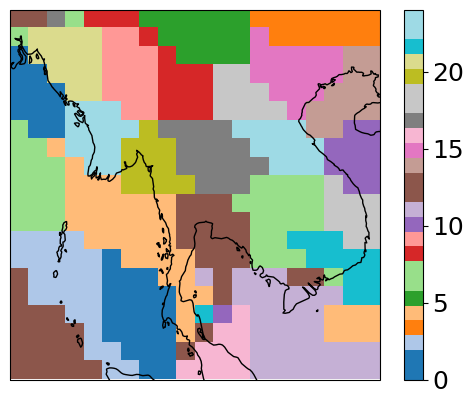

model index 35


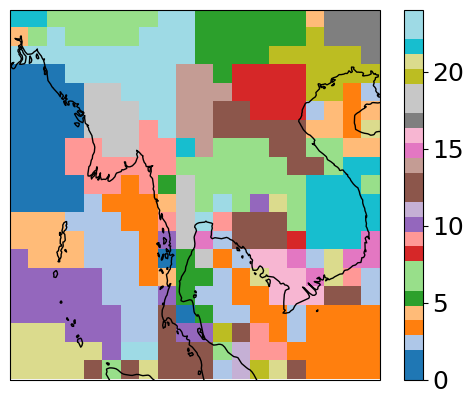

model index 36


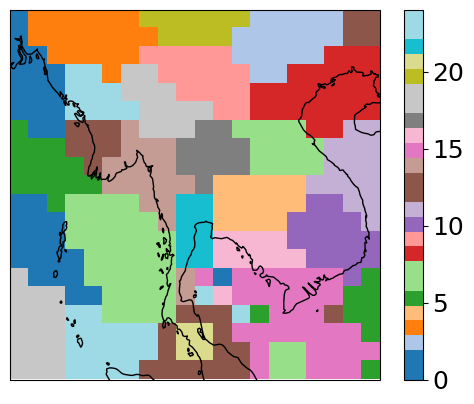

model index 37


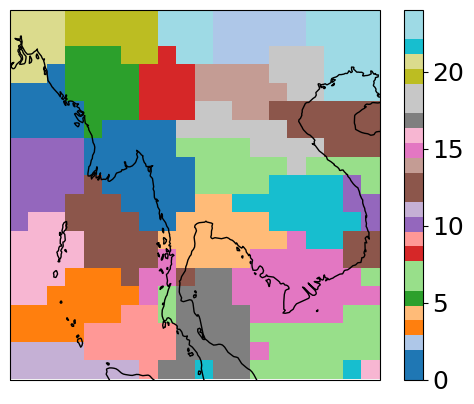

model index 38


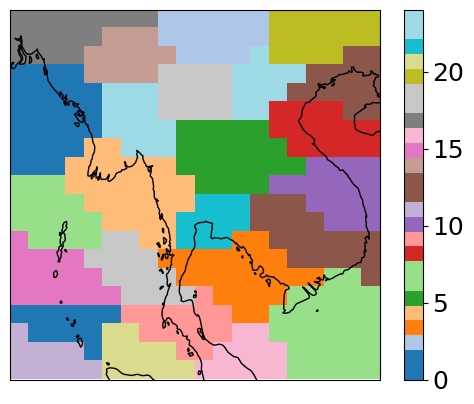

model index 39


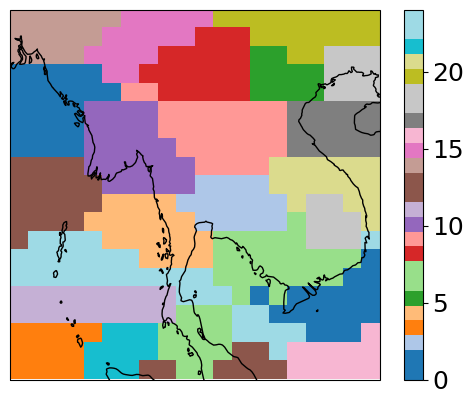

model index 40


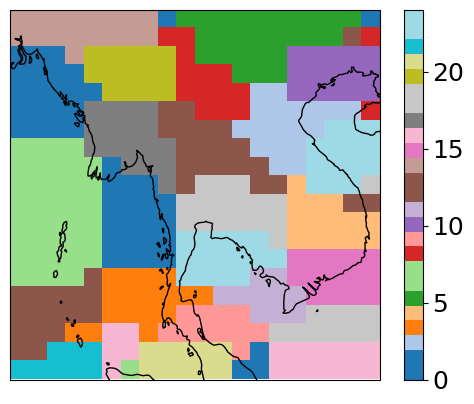

model index 41


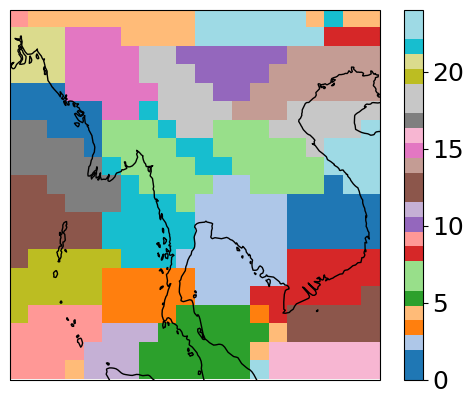

In [57]:
all_models(x)